# Pyalgotrade 기초

## 개요
[pyalgotrade tutorial]을 보면 이렇게 pyalgotrade에 대해 다음과 같이 설명 되어 있습니다.
>The goal of PyAlgoTrade is to help you backtest stock trading strategies. Let’s say you have an idea for a trading strategy and you’d like to evaluate it with historical data and see how it behaves, then PyAlgoTrade should allow you to do so with minimal effort.
[pyalgotrade tutorial]:https://gbeced.github.io/pyalgotrade/docs/v0.18/html/tutorial.html

1. pyalgotrade는 **backtest library**
2. **stock trading**을 위해 설계됨
3. **historical data, 특히 OHLC data를 통한 전략**을 위해 설계됨. → 주로 가격데이터를 사용하는 day trading이나 swing trading 전략 에 적합.

## Backtesting
![system](./img/system.png)
[출처] inside the black box: the simple truth about quantitative trading, Rishi. Narang, Wiley Finance.
위의 그림에서 alpha model의 검증을 위하기 위한 것이 back testing


## Backtesting 종류

- Research-based backtesting: 초기 단계에서 다양한 전략 발굴을 위해서 사용. 빠른 개발을 위해서 Python, R or MatLab 를 주로 사용.
- Event-based(driven) backtesting: 특정 event 발생시 원하는 처리를 정해놓음.(trading rule).  그리고 프로그램 상에서 실제 거래 상황과 유사한 조건을 만든 후 해당 전략이 어떻 performance를 보이는지 검증함.

**pyalgotrade는 event-driven bactesting software**


## Event의 종류

  - Tick Events - Signify arrival of new market data
  - Signal Events - Generation of new trading signals
  - Order Events - Orders ready to be sent to market broker
  - Fill Events - Fill information from the market broker
The pseudo-code for an Event-Driven backtesting system is as follows:

```python
while event_queue_isnt_empty():
    event = get_latest_event_from_queue();
    if event.type == "tick":
        strategy.calculate_trading_signals(event);
    else if event.type == "signal":
        portfolio.handle_signal(event);
    else if event.type == "order":
        portfolio.handle_order(event);
    else if event.type == "fill":
        portfolio.handle_fill(event)
    sleep(600);  # Sleep for, say, 10 mins```

## Requirement

python 2.7( python3는 안됨)

## Installation
pip install<br>
```
pip install pyalgotrade
```

## 주요 components
PyAlgoTrade has 6 main components:

  - Strategies
  - Feeds
  - Brokers
  - DataSeries
  - Technicals
  - Optimizer

### Strategies
These are the classes that you define that implement the trading logic. When to buy, when to sell, etc.
### Feeds
These are data providing abstractions. For example, you’ll use a CSV feed that loads bars from a CSV (Comma-separated values) formatted file to feed data to a strategy. Feeds are not limited to bars. For example, there is a Twitter feed that allows incorporating Twitter events into trading decisions.
### Brokers
Brokers are responsible for executing orders.
### DataSeries
A data series is an abstraction used to manage time series data.
### Technicals
These are a set of filters that you use to make calculations on top of DataSeries. For example SMA (Simple Moving Average), RSI (Relative Strength Index), etc. These filters are modeled as DataSeries decorators.
### Optimizer
These are a set of classes that allow you to distribute backtesting among different computers, or different processes running in the same computer, or a combination of both. They make horizontal scaling easy.


## 주요 class 소개

### Bar(abstract)
![bar](./img/bar.png)
### feed(abstract)
![feed](./img/feed.png)
### barfeed
![barfeed](./img/membffeed.png)
__bars: 
- key: instrument
- value: bar(OHCL + volume)
### yahoofeed
기본적으로 csv 로부터 feed data를 추가
![yahoofeed](./img/yahoofeed.png)
### Strategy
Strategies are the classes that you define that implement the trading logic, when to buy, when to sell, etc.
Buying and selling can be done in two ways:

  - Placing individual orders using any of the following methods:
    - pyalgotrade.strategy.BaseStrategy.marketOrder()
    - pyalgotrade.strategy.BaseStrategy.limitOrder()
    - pyalgotrade.strategy.BaseStrategy.stopOrder()
    - pyalgotrade.strategy.BaseStrategy.stopLimitOrder()
  - Using a higher level interface that wrap a pair of entry/exit orders:
    - pyalgotrade.strategy.BaseStrategy.enterLong()
    - pyalgotrade.strategy.BaseStrategy.enterShort()
    - pyalgotrade.strategy.BaseStrategy.enterLongLimit()
    - pyalgotrade.strategy.BaseStrategy.enterShortLimit()

Positions are higher level abstractions for placing orders. They are escentially a pair of entry-exit orders and provide easier tracking for returns and PnL than using individual orders.
### Position
Positions are higher level abstractions for placing orders. They are escentially a pair of entry-exit orders and allow to track returns and PnL easier that placing orders manually.
![strategy](./img/strategy.png)
### stratanalyzer
Strategy analyzers provide an extensible way to attach different calculations to strategy executions.

- Return
- Sharpe Ratio : $$\frac{E(return)-r_{f}}{\sigma}$$
- DrowDown: locally 가장 고가에서 저가까지의 차이
- Trades

-------
# 예제

## 진행순서
데이터 가져오기 -> feed 만들기(dataframe용) -> Strategy 만들기(볼린저밴드 전략) -> 전략 평가

## 데이터 가져오기
cybos plus로부터 종가 데이터를 가져오는 예제 입니다.
데이터를 cybos plus로 부터 가져와 pandas dataframe 형태로 만들기위해 다음의 함수를 만듭니다.

In [1]:
import pandas as pd
import win32com.client as com
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline  

def getBarsFromCybos(code, start_date, end_date):
    stockChart = com.Dispatch('CpSysDib.StockChart')
    stockChart.SetInputValue(0, code)
    stockChart.SetInputValue(1, ord('1'))
    stockChart.SetInputValue(3, start_date.strftime("%Y%m%d"))
    stockChart.SetInputValue(2, end_date.strftime("%Y%m%d"))
    stockChart.SetInputValue(5, [0, 2, 3, 4, 5, 8])
    stockChart.SetInputValue(6, ord('D'))
    stockChart.SetInputValue(9, ord('1'))
    
    stockChart.BlockRequest()
    numData = stockChart.GetHeaderValue(3)
    df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    for i in range(numData):
        df.loc[i]=[datetime.strptime(str(stockChart.GetDataValue(0, i)), "%Y%m%d") \
                   , stockChart.GetDataValue(1, i) \
                   , stockChart.GetDataValue(2, i) \
                   , stockChart.GetDataValue(3, i) \
                   , stockChart.GetDataValue(4, i) \
                   , stockChart.GetDataValue(5, i)]
         
    return df

하이닉스(000660) 주가 데이터를 가져와 봅니다

In [2]:
hynix = getBarsFromCybos("A000660", date(2015, 1, 1), date(2016, 12, 29))
hynix.head(10)

,Date,Open,High,Low,Close,Volume
0,2016-12-29,45150.0,45200.0,44600.0,44700.0,1808856.0
1,2016-12-28,45350.0,45750.0,45100.0,45350.0,1296254.0
2,2016-12-27,45550.0,45950.0,45400.0,45650.0,1175619.0
3,2016-12-26,46200.0,46600.0,45250.0,45650.0,1603230.0
4,2016-12-23,46200.0,46400.0,45950.0,46300.0,2982024.0
5,2016-12-22,46000.0,46650.0,45150.0,45500.0,4045912.0
6,2016-12-21,45500.0,45750.0,45000.0,45000.0,1662010.0
7,2016-12-20,45400.0,45550.0,44950.0,45150.0,1110753.0
8,2016-12-19,46250.0,46300.0,45050.0,45150.0,1997194.0
9,2016-12-16,45800.0,46450.0,45700.0,46400.0,2100809.0


##  DataFrame용 BarFeed만들기
기본적으로 제공되는 barfeed의 경우 csv를 통한 데이터 읽기만을 지원합니다. dataframe형태의 데이터로 barfeed를 만들기 위해서 다음의 class를 만듭니다.
- Feed: membf.BarFeed를 기반으로한 DataFrame을 통해 Feed에 데이터를 추가할 수 있도록 한 Class. csvfeed.BarFeed를 참고하여 작성함. addBarsFromCsv 대신 addBarsFromDf를 통해 Feed에 Bar를 추가
- RowParser: data row를 bar로 변환하는 기능.

In [3]:
from pyalgotrade.barfeed import membf
from pyalgotrade import bar

import datetime

class Feed(membf.BarFeed):
    def __init__(self, frequency=bar.Frequency.DAY, timezone=None, maxLen=None):
        if isinstance(timezone, int):
            raise Exception("timezone as an int parameter is not supported anymore. Please use a pytz timezone instead.")

        if frequency not in [bar.Frequency.DAY, bar.Frequency.WEEK]:
            raise Exception("Invalid frequency.")

        self.__timezone = timezone
        self.__barClass = bar.BasicBar
        self.__dailyTime = datetime.time(0, 0, 0)
        self.__frequency = frequency
        
        super(Feed, self).__init__(frequency, maxLen)
    
    def setBarClass(self, barClass):
        self.__barClass = barClass

    def barsHaveAdjClose(self):
        return True
        
    def getDailyBarTime(self):
        return self.__dailyTime

    def setDailyBarTime(self, time):
        self.__dailyTime = time
        
    def addBarsFromDf(self, instrument, df, rowParser=None):
        loadedBars = []
        
        if rowParser is None:
            rowParser = BasicDfRowParser(self.__dailyTime, self.__frequency)
            
        for index, row in df.iterrows():
            bar_ = rowParser.parseBar(row)
            if bar_ is not None:
                loadedBars.append(bar_)
        
        self.addBarsFromSequence(instrument, loadedBars)
        
class BasicDfRowParser():
    def __init__(self, dailyBarTime, frequency, timezone=None, barClass=bar.BasicBar):
        self.__dailyBarTime = dailyBarTime
        self.__frequency = frequency
        self.__timezone = timezone
        self.__barClass = barClass

    def getFieldNames(self):
        # It is expected for the first row to have the field names.
        return None

    def parseBar(self, row):
        dateTime = row["Date"]
        close = row["Close"]
        open_ = row["Open"]
        high = row["High"]
        low = row["Low"]
        volume = row["Volume"]
        adjClose = row["Close"]

        return self.__barClass(dateTime, open_, high, low, close, volume, adjClose, self.__frequency)

## 볼린저밴드 Strategy 만들기
볼린저 밴드에 대해서는 아래 사이트 참고<br>
http://www.nanumtrading.com/fx-%EB%B0%B0%EC%9A%B0%EA%B8%B0/%EC%B0%A8%ED%8A%B8-%EB%B3%B4%EC%A1%B0%EC%A7%80%ED%91%9C-%EC%9D%B4%ED%95%B4/05-%EB%B3%BC%EB%A6%B0%EC%A0%80%EB%B0%B4%EB%93%9C/

우선 가장 기본적인 전략인 buy and hold 전략을 짜봅니다.

In [4]:
from pyalgotrade import strategy

class BuyAndHoldStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, initialCash):
        super(BuyAndHoldStrategy, self).__init__(feed, initialCash)
        self.__position = None
        self.setUseAdjustedValues(True)
        self.__instrument = instrument
        
    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info("SELL at $%.2f" % (execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()
 
    def onBars(self, bars):
                
        if self.__position is None:
                self.__position = self.enterLong(self.__instrument, 1, True)

다음으로 볼린저 밴드의 전략을 만듭니다.

In [8]:
from pyalgotrade.technical import bollinger

class BollingerStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, initialCash, period, width):
        super(BollingerStrategy, self).__init__(feed, initialCash)
        self.__position = None
        self.setUseAdjustedValues(True)
        self.__bollinger = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), period, width)
        self.__instrument = instrument
        self.__previousClose = None   
        self.upper = []
        self.middle = []
        self.lower = []
        
    def getLower(self):
        return self.__bollinger.getLowerBand()
        
    def getUpper(self):
        return self.__bollinger.getUpperBand()
        
    def getMiddle(self):
        return self.__bollinger.getMiddleBand()        

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info("SELL at $%.2f" % (execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()
        
    def _lowerDownUpCrossOver(self, close, previousClose, lower):
        if previousClose < lower and close >= lower:
            return True
        
        return False
        
    def _upperUpDownCross(self, close, previousClose, upper):
        if previousClose > upper and close <= upper:
            return True
        
        return False
    
    def _upperDownUpCross(self, close, previousClose, upper):
        if previousClose < upper and close >= upper:
            return True
        
        return False
        
    def onBars(self, bars):
               
        bar = bars[self.__instrument]
        
        middle = self.__bollinger.getMiddleBand()
        upper = self.__bollinger.getUpperBand()
        lower = self.__bollinger.getLowerBand()       
        
        self.middle.append(middle[-1])
        self.upper.append(upper[-1])
        self.lower.append(lower[-1])
        
        if middle[-1] is None:
            return
        
        if self.__position is None:
            if self._lowerDownUpCrossOver(bar.getClose(), self.__previousClose, lower[-1]):
                self.__position = self.enterLong(self.__instrument, 1, True)
        elif self._upperUpDownCross(bar.getClose(), self.__previousClose, upper[-1]) and not self.__position.exitActive():
            self.__position.exitMarket()
        
        self.__previousClose = bar.getClose()
        

전략까지 만들었으니 위에서 받은 하이닉스 데이터로 전략을 돌려봅니다.

2015-01-05 00:00:00 strategy [INFO] BUY at $48050.00
2015-01-30 00:00:00 strategy [INFO] BUY at $48000.00
2015-04-28 00:00:00 strategy [INFO] SELL at $46150.00
2015-06-18 00:00:00 strategy [INFO] BUY at $44900.00
2015-10-13 00:00:00 strategy [INFO] SELL at $36800.00
2015-12-16 00:00:00 strategy [INFO] BUY at $30050.00
2015-12-28 00:00:00 strategy [INFO] SELL at $31750.00
2016-01-14 00:00:00 strategy [INFO] BUY at $27300.00
2016-02-22 00:00:00 strategy [INFO] SELL at $29400.00
2016-04-11 00:00:00 strategy [INFO] BUY at $27600.00
2016-04-29 00:00:00 strategy [INFO] SELL at $27700.00
2016-05-11 00:00:00 strategy [INFO] BUY at $26500.00
2016-06-29 00:00:00 strategy [INFO] SELL at $31800.00
2016-11-11 00:00:00 strategy [INFO] BUY at $40000.00
2016-12-12 00:00:00 strategy [INFO] SELL at $45750.00


Buy and Hold: Final portfolio value: $196650.00
Bollinger Band: Final portfolio value: $205000.00


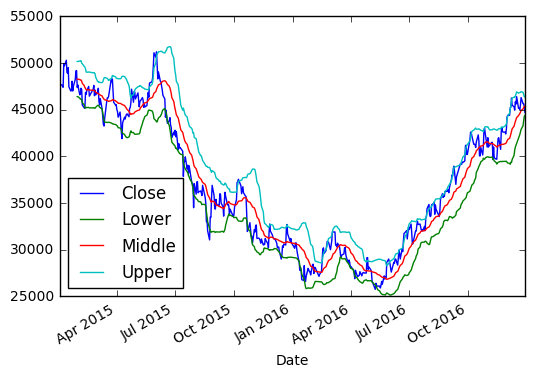

In [9]:
from pyalgotrade import plotter

hynix.index = hynix['Date']
initialCash = 200000

## buy and hold 전략 ##
feed = Feed()
feed.addBarsFromDf('hynix', hynix)
buyandhold = BuyAndHoldStrategy(feed, 'hynix', initialCash)

buyandhold.run()
print "Buy and Hold: Final portfolio value: $%.2f" % buyandhold.getBroker().getEquity()

## 볼린저밴드 전략 ##
## feed 커서가 eof에 있으니 초기화 합니다.
feed.reset()
myStrategy = BollingerStrategy(feed, 'hynix', initialCash, 20, 1.8)
myStrategy.run()
print "Bollinger Band: Final portfolio value: $%.2f" % myStrategy.getBroker().getEquity()

plotData = pd.DataFrame(data={'Close':hynix['Close'], 'Upper': list(reversed(myStrategy.upper)), \
                              'Lower': list(reversed(myStrategy.lower)), \
                              'Middle': list(reversed(myStrategy.middle))}, index= hynix['Date'])

plotData.plot()

## 전략평가하기
strategyanalyzer로 전략을 평가해 봅니다.

In [18]:
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.stratanalyzer import returns
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import drawdown
from pyalgotrade.stratanalyzer import trades

feed = Feed()
feed.addBarsFromDf('hynix', hynix)

myStrategy = BollingerStrategy(feed, 'hynix', initialCash, 20, 1.8)

retAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(retAnalyzer)
sharpeRatioAnalyzer = sharpe.SharpeRatio()
myStrategy.attachAnalyzer(sharpeRatioAnalyzer)
drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)
tradesAnalyzer = trades.Trades()
myStrategy.attachAnalyzer(tradesAnalyzer)

myStrategy.run()

print "Final portfolio value: $%.2f" % myStrategy.getResult()
print "Cumulative returns: %.2f %%" % (retAnalyzer.getCumulativeReturns()[-1] * 100)
print "Sharpe ratio: %.2f" % (sharpeRatioAnalyzer.getSharpeRatio(0.02))
print "Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100)
print "Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration())

print
print "Total trades: %d" % (tradesAnalyzer.getCount())
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print "Avg. profit: $%2.f" % (profits.mean())
    print "Profits std. dev.: $%2.f" % (profits.std())
    print "Max. profit: $%2.f" % (profits.max())
    print "Min. profit: $%2.f" % (profits.min())
    returns = tradesAnalyzer.getAllReturns()
    print "Avg. return: %2.f %%" % (returns.mean() * 100)
    print "Returns std. dev.: %2.f %%" % (returns.std() * 100)
    print "Max. return: %2.f %%" % (returns.max() * 100)
    print "Min. return: %2.f %%" % (returns.min() * 100)

print
print "Profitable trades: %d" % (tradesAnalyzer.getProfitableCount())
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print "Avg. profit: $%2.f" % (profits.mean())
    print "Profits std. dev.: $%2.f" % (profits.std())
    print "Max. profit: $%2.f" % (profits.max())
    print "Min. profit: $%2.f" % (profits.min())
    returns = tradesAnalyzer.getPositiveReturns()
    print "Avg. return: %2.f %%" % (returns.mean() * 100)
    print "Returns std. dev.: %2.f %%" % (returns.std() * 100)
    print "Max. return: %2.f %%" % (returns.max() * 100)
    print "Min. return: %2.f %%" % (returns.min() * 100)

print
print "Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount())
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print "Avg. loss: $%2.f" % (losses.mean())
    print "Losses std. dev.: $%2.f" % (losses.std())
    print "Max. loss: $%2.f" % (losses.min())
    print "Min. loss: $%2.f" % (losses.max())
    returns = tradesAnalyzer.getNegativeReturns()
    print "Avg. return: %2.f %%" % (returns.mean() * 100)
    print "Returns std. dev.: %2.f %%" % (returns.std() * 100)
    print "Max. return: %2.f %%" % (returns.max() * 100)
    print "Min. return: %2.f %%" % (returns.min() * 100)

2015-01-30 00:00:00 strategy [INFO] BUY at $48000.00
2015-04-28 00:00:00 strategy [INFO] SELL at $46150.00
2015-06-18 00:00:00 strategy [INFO] BUY at $44900.00
2015-10-13 00:00:00 strategy [INFO] SELL at $36800.00
2015-12-16 00:00:00 strategy [INFO] BUY at $30050.00
2015-12-28 00:00:00 strategy [INFO] SELL at $31750.00
2016-01-14 00:00:00 strategy [INFO] BUY at $27300.00
2016-02-22 00:00:00 strategy [INFO] SELL at $29400.00
2016-04-11 00:00:00 strategy [INFO] BUY at $27600.00
2016-04-29 00:00:00 strategy [INFO] SELL at $27700.00
2016-05-11 00:00:00 strategy [INFO] BUY at $26500.00
2016-06-29 00:00:00 strategy [INFO] SELL at $31800.00
2016-11-11 00:00:00 strategy [INFO] BUY at $40000.00
2016-12-12 00:00:00 strategy [INFO] SELL at $45750.00


Final portfolio value: $205000.00
Cumulative returns: 2.50 %
Sharpe ratio: -0.13
Max. drawdown: 7.99 %
Longest drawdown duration: 602 days 00:00:00

Total trades: 7
Avg. profit: $714
Profits std. dev.: $4374
Max. profit: $5750
Min. profit: $-8100
Avg. return:  4 %
Returns std. dev.: 12 %
Max. return: 20 %
Min. return: -18 %

Profitable trades: 5
Avg. profit: $2990
Profits std. dev.: $2180
Max. profit: $5750
Min. profit: $100
Avg. return: 10 %
Returns std. dev.:  7 %
Max. return: 20 %
Min. return:  0 %

Unprofitable trades: 2
Avg. loss: $-4975
Losses std. dev.: $3125
Max. loss: $-8100
Min. loss: $-1850
Avg. return: -11 %
Returns std. dev.:  7 %
Max. return: -4 %
Min. return: -18 %
